In [1]:
!pip install tensorflow

     |████████████████████████████████| 511.7 MB 89 kB/s s eta 0:00:01     |███████████████████████████████ | 494.1 MB 29.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 33.5 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 156 kB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 26.3 MB/s eta 0:00:01
     |███████████████████████████

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
#from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

2022-05-18 18:00:01.447343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 18:00:01.447365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [4]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [7]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

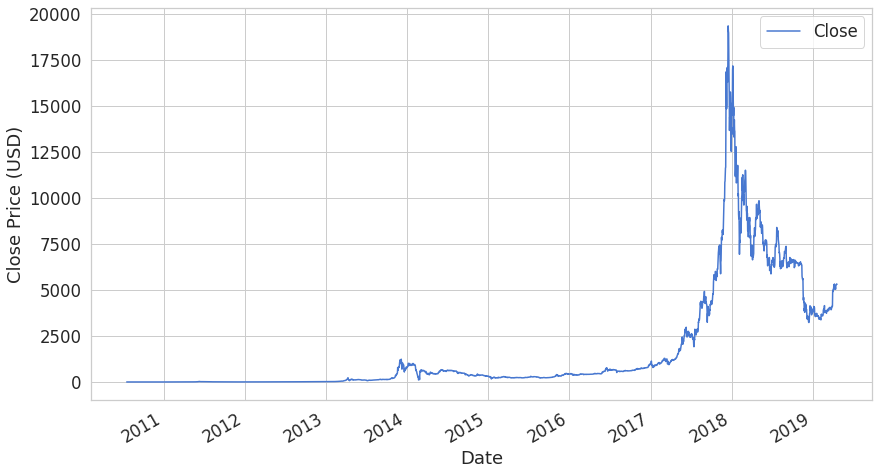

In [8]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [9]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(3201, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(2945, 99, 1)

In [17]:
X_test.shape

(156, 99, 1)

# Model

In [19]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [20]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [21]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 48s 946ms/step - loss: 7.8196e-04 - val_loss: 0.0404
Epoch 2/50
42/42 [==============================] - 35s 827ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3/50
42/42 [==============================] - 42s 1000ms/step - loss: 0.0011 - val_loss: 0.0309
Epoch 4/50
42/42 [==============================] - 38s 897ms/step - loss: 0.0045 - val_loss: 0.0599
Epoch 5/50
42/42 [==============================] - 44s 1s/step - loss: 0.0112 - val_loss: 0.0066
Epoch 6/50
42/42 [==============================] - 44s 1s/step - loss: 0.0081 - val_loss: 0.0024
Epoch 7/50
42/42 [==============================] - 37s 891ms/step - loss: 0.0094 - val_loss: 0.0237
Epoch 8/50
42/42 [==============================] - 41s 966ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 9/50
42/42 [==============================] - 36s 855ms/step - loss: 0.0099 - val_loss: 0.0361
Epoch 10/50
42/42 [==============================] - 37s 875ms/step - loss: 0.0022 - val_los

In [22]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 85ms/step - loss: 0.0011


0.0010805813362821937

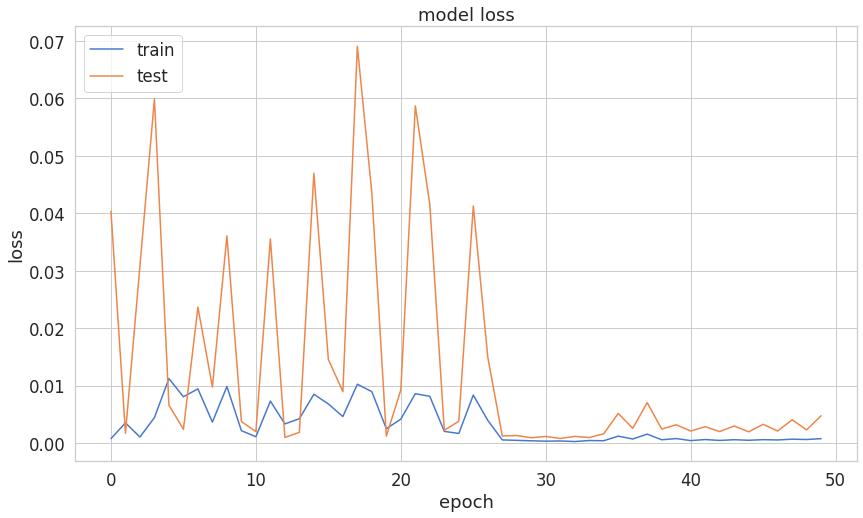

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [25]:
X_test.shape

(156, 99, 1)

5/5 [==============================] - 2s 95ms/step


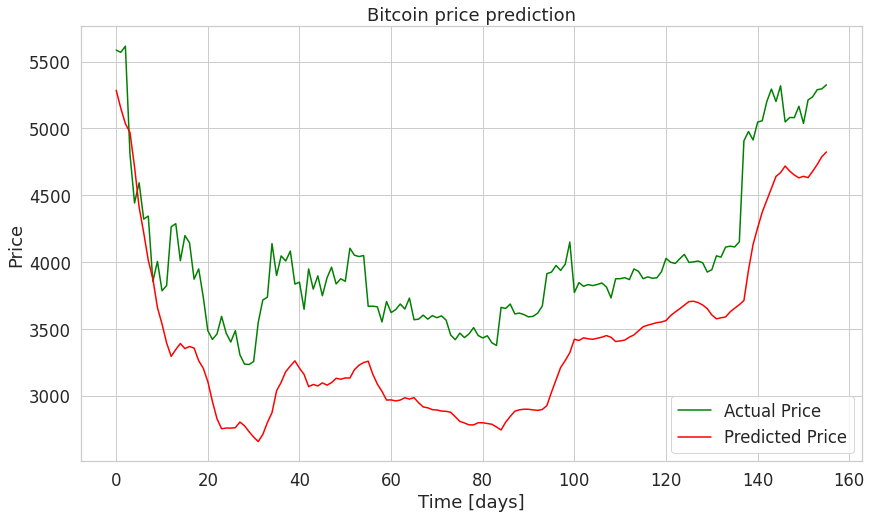

In [24]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();